In [222]:
#TODO: Can I put this in another file and import it somehow?
from pynq import DefaultIP
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import sem
from time import time, sleep

class ROControlDriver(DefaultIP):
    def __init__(self, description):
        super().__init__(description=description)
        self.rm = self.register_map
    
    bindto = ['wiresboy.github.io:Brandon:axi_ro_control:1.1.1']
    
    def reset_ro(self):
        self.rm.Control[0] = 1
    
    def start_acquire(self):
        self.rm.Control[1] = 1
    
    @property
    def ro_quantity(self):# ROs enabled
        return self.rm.ro_quantity[31:16]
    @ro_quantity.setter
    def ro_quantity(self, num_ro_enabled):
        self.rm.RO_Quantity_Control[31:16] = num_ro_enabled
        
    
    @property
    def cycles(self): # cycles/integration
        return self.rm.RO_Quantity_Control[15:0]
    @cycles.setter
    def cycles(self, cycles_per_integration):
        self.rm.RO_Quantity_Control[15:0] = cycles_per_integration
    
    
    @property
    def power_virus(self): # of PV enabled
        #return self.rm.Power_Virus_Control
        return self.rm.Power_Virus_Level_01[15:0]
    @power_virus.setter
    def power_virus(self, num_power_virus):
        #self.rm.Power_Virus_Control = num_power_virus
        #All states of FSM get set to same value
        if isinstance(num_power_virus, list):
            self.power_virus_fsm = num_power_virus
        else:
            self.rm.Power_Virus_Level_01[15:0]  = num_power_virus
            self.rm.Power_Virus_Level_01[31:16] = num_power_virus
            self.rm.Power_Virus_Level_23[15:0]  = num_power_virus
            self.rm.Power_Virus_Level_23[31:16] = num_power_virus
    
    
    @property
    def power_virus_fsm(self): # of PV enabled
        rm = self.rm
        return [ (rm.Power_Virus_Level_01[15:0],  rm.Power_Virus_Cycles_01[15:0] ),
                 (rm.Power_Virus_Level_01[31:16], rm.Power_Virus_Cycles_01[31:16]),
                 (rm.Power_Virus_Level_23[15:0],  rm.Power_Virus_Cycles_23[15:0] ),
                 (rm.Power_Virus_Level_23[31:16], rm.Power_Virus_Cycles_23[31:16])]
    @power_virus_fsm.setter
    def power_virus_fsm(self, fsm_config):
        
        self.rm.Power_Virus_Level_01[15:0]  = fsm_config[0][0]
        self.rm.Power_Virus_Level_01[31:16] = fsm_config[1][0]
        self.rm.Power_Virus_Level_23[15:0]  = fsm_config[2][0]
        self.rm.Power_Virus_Level_23[31:16] = fsm_config[3][0]
        
        self.rm.Power_Virus_Cycles_01[15:0]  = fsm_config[0][1]
        self.rm.Power_Virus_Cycles_01[31:16] = fsm_config[1][1]
        self.rm.Power_Virus_Cycles_23[15:0]  = fsm_config[2][1]
        self.rm.Power_Virus_Cycles_23[31:16] = fsm_config[3][1]
     
    
    @property
    def mode(self): # mode: 1=continuous, 0=one shot
        return self.rm.Mode[0]
    @mode.setter
    def mode(self, mode):
        self.rm.Mode[0] = mode
        
    @property
    def status(self): #Status byte
        return self.rm.Control[7:0]  #Some bits of current index into bram
    
    @property
    def last_read_sum(self):
        return self.rm.Control[31:16] 
    


class XADCDriver(DefaultIP):
    def __init__(self, description):
        super().__init__(description=description)
    
    bindto = ['xilinx.com:ip:xadc_wiz:3.3']

    @property
    def temperature_raw(self):
        return self.read(0x200) >> 4
    @property
    def temperature_c(self):
        return (self.temperature_raw * 503.975/4096)-273.15
    @property
    def temperature_f(self):
        return ((self.temperature_raw * 503.975/4096)-273.15)*9/5 +32
    
    @property
    def vccint_raw(self):
        return self.read(0x204) >> 4
    @property
    def vccint(self):
        return self.vccint_raw *3/4096
    
    @property
    def vccaux_raw(self):
        return self.read(0x208) >> 4
    @property
    def vccaux(self):
        return self.vccaux_raw *3/4096
    
    @property
    def vccbram_raw(self):
        return self.read(0x218) >> 4
    @property
    def vccbram(self):
        return self.vccbram_raw *3/4096
    
    @property
    def vccpint_raw(self):
        return self.read(0x234) >> 4
    @property
    def vccpint(self):
        return self.vccpint_raw *3/4096

def get_scaling(ro_cycles, ro_quantity):
    return  (ro_cycles-2) * ro_quantity / (ps.Clocks.fclk1_mhz * 1000000) 

def scale(value, scaling): #period = (ro_cycles-2) / clkfreq(hz)
    return value/scaling

def get_bram(ro_cycles, ro_quantity):
    scaling=get_scaling(ro_cycles, ro_quantity)
    return [scale(bram.read(offset=x),scaling) for x in range(0,bram.length, 4)]

def get_bram_durationms(ro_cycles, ro_quantity, durationms):
    scaling=get_scaling(ro_cycles, ro_quantity)
    count = int(durationms * (ps.Clocks.fclk1_mhz * 1000) / ro_cycles )
    return [scale(bram.read(offset=x),scaling) for x in range(0,min(bram.length, count*4), 4)]

#SW power virus
def swPV():
    zz = 1;
    for x in range(1,100000):
        zz = zz*x

def swSpeedTest():
    ro.power_virus = 0x0000

def swSpeedTestAlt():
    ro.power_virus = [(0xfc00, 0x4fff),
                      (0xfff0, 0x4fff),
                      (0xfc00, 0x4fff),
                      (0x0000, 0x2fff)]
    

    
#Generate X axis timestamps based on current ro, clk parameters
def timeList_us(l): 
    period = (ro.cycles+1) / (ps.Clocks.fclk1_mhz * 1000000)*1e6 #Scale to us
    print("period",period)
    return [x*period for x in range(l)]
    

#Return: list of values
def run_test(ro_quantity=1, ro_cycles = 2, power_virus = 0, swFunc = None, durationms = None):
    sleep(1)
    ro.ro_quantity = ro_quantity
    ro.cycles = ro_cycles
    ro.power_virus = power_virus
    ro.mode = 0 # One-shot
    ro.reset_ro()
    ro.start_acquire()
    if swFunc is not None:
        swFunc()
    while (ro.status < 0xff): #Wait for acquisition to finish. 
        #TODO: How to tell when long-duration tests are done? This doesn't show all the bits...
        pass
    sleep(0.2)
    if durationms is not None:
        return get_bram_durationms(ro_cycles, ro_quantity, durationms)
    else:
        return get_bram(ro_cycles, ro_quantity)

plt.rcParams['figure.figsize'] = [16, 10]

In [34]:
from pynq import Overlay
from pynq import ps
overlay = Overlay("z2_voltage_experiments_wrapper.bit")

ro = overlay.axi_ro_control_0
xadc=overlay.xadc_wiz_0
bram = overlay.axi_bram_ctrl_0.mmio
print(ps.Clocks.fclk0_mhz, ps.Clocks.fclk1_mhz)

#ps.Clocks.fclk0_mhz = 100 #Default 66MHz ??
ps.Clocks.fclk1_mhz = 50 #Default 125MHz ??

print(ps.Clocks.fclk0_mhz, ps.Clocks.fclk1_mhz)

100.0 125.0
100.0 100.0


1579875000.0
1677357015.335317
1728625000.0
period 0.16019999999999998


0

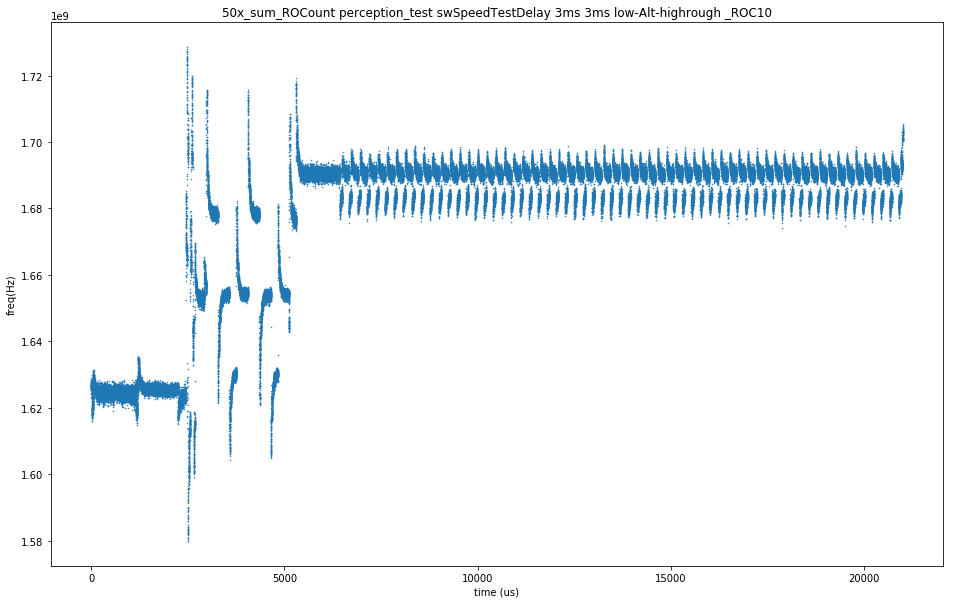

In [80]:
plt.rcParams['figure.figsize'] = [16, 10]
PVoscillate0 = [(0x0000, 2000),
               (0x0000, 2000),
               (0x0000, 2000),
               (0x0000, 2000)]

PVoscillateF = [(0xffff, 2000),
               (0xffff, 2000),
               (0xffff, 2000),
               (0xffff, 2000)]

PVoscillateAlt = [(0xfc00, 0x4fff),
                  (0xfff0, 0x4fff),
                  (0xfc00, 0x4fff),
                  (0x0000, 0x2fff)]

#name = "0000 always"
#name = "ffff always"
#name = "fc00_fff0_fc00_0000 at llls"
name = "perception_test swSpeedTestDelay 3ms 3ms low-Alt-highrough"

def swSpeedTestDelay():
    sleep(0.003)
    ro.power_virus = [(0xfc00, 0x4fff),
                      (0xfff0, 0x4fff),
                      (0xfc00, 0x4fff),
                      (0x8000, 0x2fff)]
    sleep(0.003)
    ro.power_virus = [(0xffff, 4000),
                      (0xffff, 4000),
                      (0xffff, 4000),
                      (0x7fff, 4000)]

ro_quantity = 50
ro_cycles = 10
b=run_test(ro_quantity=ro_quantity, ro_cycles = ro_cycles, power_virus = PVoscillate0, swFunc = swSpeedTestDelay)#swSpeedTestAlt_20ms)
ro.power_virus=0x8000

b=b[1:-1]

print(min(b))
print(sum(b)/len(b))
print(max(b))

plt.plot(timeList_us(len(b)), b, linestyle="none", marker=".", markersize=1)
plt.xlabel("time (us)")
plt.ylabel("freq(Hz)")
plt.title(str(ro_quantity)+"x_sum_ROCount "+name+" _ROC"+str(ro_cycles))
plt.savefig("png/"+str(ro_quantity)+"x_sum_ROCount realfreq "+name+" _ROC"+str(ro_cycles)+" "+str(int(time())%100000)+".png", dpi=150)

ro.power_virus = 0
0

0
period 0.4602


0

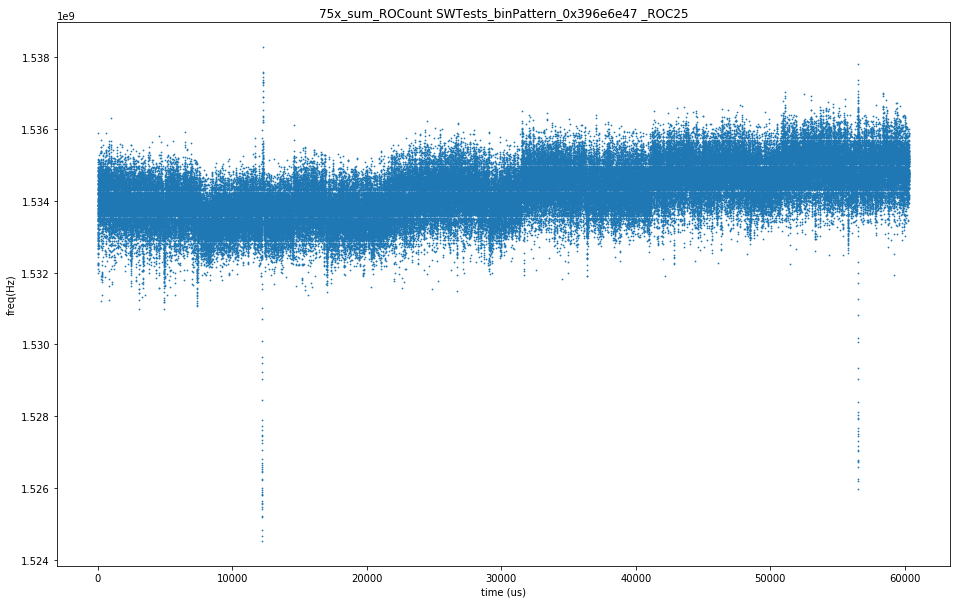

In [228]:
# PV test: Custom Functions

def func_pass(): #Draw some power!
    pass

def func_intMul10000000(): #Draw some power!
    sleep(0.010) #Wait 10ms to give baseline
    y=1
    for x in range(1,10000000):
        y=y*x

def func_floatMul4000(): #Draw some power! For ~3ms
    sleep(0.003)
    y=1.001
    for x in range(1,4000):
        y=y*x


def func_hp3ms(): #Draw some power!
    y=7
    for x in range(1,8):
        y=(y**x)

def func_lp3ms():
    y=7
    for x in range(1,10000):
        pass

    
def func_hp100us(): #Draw some power!
    y=7
    for x in range(1,7):
        y=(y**x)

def func_lp100us():
    y=7
    for x in range(1,450):
        pass
        
def func_floatAlt1():
    for z in range(15):
        if (z%2 ==0):
            func_hp3ms()
        else:
            func_lp3ms()
            
def func_floatAlt2():
    for z in range(1000):
        if (z%2 ==0):
            func_hp100us()
        else:
            func_lp100us()

def func_binPattern():
    for a in range(20):
        val = 0x396e6e47
        for z in range(32):
            bit = val&1
            val = val>>1
            if (bit):
                func_hp3ms()
            else:
                func_lp3ms()
    print(val)

    

def func_binPatternFast():
    for a in range(20):
        val = 0xacf0ff00
        for z in range(32):
            bit = val&1
            val = val>>1
            if (bit):
                func_hp100us()
            else:
                func_lp100us()
    print(val)

#func=func_intMul10000000
#name = "SWTests_intMul10000000"

#func=func_floatMul4000
#name = "SWTests_floatMul4000"

#func=func_pass
#name = "SWTests_pass"

#func=func_floatAlt1
#name = "SWTests_floatAlt1_dev"
#func=func_floatAlt2
#name = "SWTests_floatAlt2_dev"
func=func_binPattern
name = "SWTests_binPattern_0x396e6e47"
#func=func_binPatternFast
#name = "SWTests_binPatternFast_0xacf0ff00"

ro_quantity = 75
ro_cycles = 25
ro.power_virus = 0xffff
b=run_test(ro_quantity=ro_quantity, ro_cycles = ro_cycles, power_virus = 0, swFunc = func, durationms=None)[1:-1]
ro.power_virus=0x7fff

b=b

plt.plot(timeList_us(len(b)), b, linestyle="none", marker=".", markersize=1.5)
plt.xlabel("time (us)")
plt.ylabel("freq(Hz)")
plt.title(str(ro_quantity)+"x_sum_ROCount "+name+" _ROC"+str(ro_cycles))
plt.savefig("png/"+str(ro_quantity)+"x_sum_ROCount realfreq "+name+" _ROC"+str(ro_cycles)+" "+str(int(time())%100000)+".png", dpi=150)

ro.power_virus = 0xffff
0

In [175]:
import numpy

period 0.4602
period 0.4602


Text(0.5,1,'75x_sum_ROCount SWTests_binPattern_0x396e6e47 _ROC25')

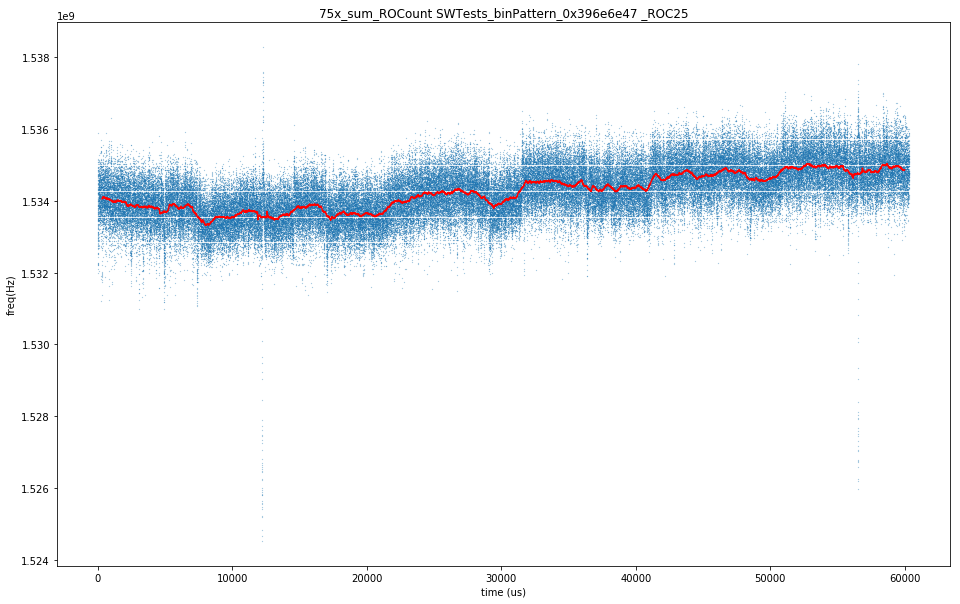

In [232]:
c=b#[1000:3500]
window_width=1500
cumsum_vec = numpy.cumsum(c) 
ma_vec = (cumsum_vec[window_width:] - cumsum_vec[:-window_width]) / window_width

plt.plot(timeList_us(len(c)), c, linestyle="none", marker=".", markersize=0.3)
plt.plot(timeList_us(len(c))[int(window_width/2):-int(window_width/2)], ma_vec, "r")
plt.xlabel("time (us)")
plt.ylabel("freq(Hz)")
plt.title(str(ro_quantity)+"x_sum_ROCount "+name+" _ROC"+str(ro_cycles))

#0xaaccacf0
#Flip to binary:
#00001111001101010011001101010101

In [167]:
from timeit import timeit
def func_timeit(): #Draw some power!
    y=7
    for x in range(1,7):
        y=(y**x)
print(timeit(func_timeit,number=1000))

def func_timeit2(): #Draw some power!
    y=7
    for x in range(1,450):
        pass
print(timeit(func_timeit2,number=1000))


0.09048782201716676
0.09359579300507903


In [130]:
'''Final Pres: 
On Wednesday
15 minutes or less
pres+demo
- Background
- Project Overview
- Results (demo optional), clearly explain experiment setup and the results
- Challenges tackled/remaining, lessons learned, other stuff to share
- leave time for Q&A

Feedback optional: 5pm Tuesday



Final Report: Wednesday 12/9, can extend to 12/14 without penalty
Format: (copy a lot from prior reports)
- Intro
- Background
- Overview/Approaches/Challenges/Tech Details
- Evaluation of results
- Potential future work
  - Some goals that planned but could not complete (not losing points here!)
  - Estimation of challenges/difficulties
- Conclusion
- Appendix: Lessons learned, anything you would like to tlak about the project, etc.
'''

'Final Pres: \nOn Wednesday\n15 minutes or less\npres+demo\n- Background\n- Project Overview\n- Results (demo optional), clearly explain experiment setup and the results\n- Challenges tackled/remaining, lessons learned, other stuff to share\n- leave time for Q&A\n\nFeedback optional: 5pm Tuesday\n\n\n\nFinal Report: Wednesday 12/9, can extend to 12/14 without penalty\nFormat: (copy a lot from prior reports)\n- Intro\n- Background\n- Overview/Approaches/Challenges/Tech Details\n- Evaluation of results\n- Potential future work\n  - Some goals that planned but could not complete (not losing points here!)\n  - Estimation of challenges/difficulties\n- Conclusion\n- Appendix: Lessons learned, anything you would like to tlak about the project, etc.\n'

In [145]:
len(b)

131070

In [216]:
print(xadc.temperature_c)
ro.power_virus = 0xffff
for x in range(10):
    print(xadc.temperature_c)
    sleep(0.005)

63.489550781250045
63.735632324218784
63.735632324218784
63.612591552734386
63.24346923828131
63.735632324218784
63.98171386718752
63.489550781250045
64.35083618164066
62.99738769531251
63.24346923828131


0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


0

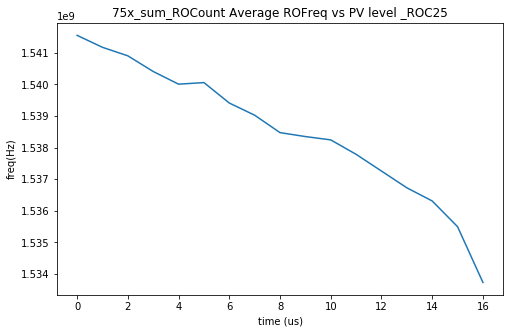

In [236]:
ro_quantity = 75
ro_cycles = 25
ro.power_virus = 0xffff

res = []
plt.rcParams['figure.figsize'] = [8, 5]

for x in range(17):
    ro.power_virus = 0xffff>>x
    sleep(1)
    b=run_test(ro_quantity=ro_quantity, ro_cycles = ro_cycles, power_virus = 0, swFunc = func, durationms=None)[1:-1]
    dp = sum(b)/len(b)
    res.append(dp)

name = "Average ROFreq vs PV level"

plt.plot(range(16,-1, -1), res)
plt.xlabel("time (us)")
plt.ylabel("freq(Hz)")
plt.title(str(ro_quantity)+"x_sum_ROCount "+name+" _ROC"+str(ro_cycles))
plt.savefig("png/"+str(ro_quantity)+"x_sum_ROCount realfreq "+name+" _ROC"+str(ro_cycles)+" "+str(int(time())%100000)+".png", dpi=150)

ro.power_virus = 0xffff

plt.rcParams['figure.figsize'] = [16, 10]
0